# Scalability of different methods in terms of network depth

In [2]:
import sys
import numpy as np

sys.path.append('..')

import torch 
import matplotlib.pyplot as plt

from relu_nets import ReLUNet  
from hyperbox import Hyperbox  
from lipMIP import LipMIP
from other_methods import LipSDP, StochasticApproximation, StochasticApproximationUCBDynamic

## 60 Seconds test
Test determines maximum depth of network that can be evaluated in 60 seconds by methods

In [3]:
import time 

def run_time_test(max_duration, networks, sample_domain, c_vector, SA_iter_limit, methods, verbose=False):
    max_depth = {m: [] for m in methods}
    res = {m: [] for m in methods}
    
    for method in methods:
        start_time = time.time()
        hidden_layers = 1
        while time.time() - start_time < max_duration:
            test_network = networks[hidden_layers-1]
            result = None
            
            # Stochastic approximation
            if method == "Stochastic Approximation":
                SA = StochasticApproximation(test_network, c_vector, sample_domain, use_c_vector=True)
                result = SA.compute(max_iter=SA_iter_limit, v=False)
            
            if method == "Stochastic Approximation UCB":
                SA = StochasticApproximationUCBDynamic(test_network, c_vector, sample_domain, c=1, partition_step=2, use_c_vector=True)
                result = SA.compute(max_iter=SA_iter_limit, v=False)
                
            # LipMIP
            if method == "LipMIP":
                simple_prob = LipMIP(test_network, sample_domain, c_vector, verbose=False, num_threads=5, timeout=max_duration+1)
                simple_result = simple_prob.compute_max_lipschitz()
                result = simple_result.as_dict()["value"]
                
            # LipSDP
            if method == "LipSDP":
                LSDP = LipSDP(network=test_network, c_vector=c_vector, domain=sample_domain)
                result = LSDP.compute() * np.sqrt(2) # Because LipSDP overestimates L2 norm, scaling with sqrt(input_dim) needed
            
            current_time = time.time()
            elapsed_time = current_time - start_time
            if verbose:
                print(f"({method})END hidden layers = {hidden_layers}, res={result}, time = {elapsed_time}\n")
            if elapsed_time <= max_duration:
                max_depth[method].append(elapsed_time)
                res[method].append(result)
                
            
            hidden_layers += 1
        
    print("Test finished.")
    return max_depth, res

def plot_results_seconds(max_depth, res, dim, SA_iter_limit, methods):
    markers = {"LipMIP": "X", "Stochastic Approximation": "o", "LipSDP": "D", "Stochastic Approximation UCB": "."}
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    for method in methods:
        ax1.plot(np.arange(1, len(max_depth[method])+1), max_depth[method], '-', marker=markers[method], label=method)
        
    ax1.set_xlabel('Number of hidden layers (width 64)')
    ax1.set_ylabel('Seconds')
    ax1.legend()
    ax1.grid(True)
    
    for method in methods:
        if method == "Stochastic Approximation UCB":
            s = '-'
            result = [r.detach().numpy().squeeze() for r in res[method]]
        else:
            result = res[method]
            s = '-'
        
        ax2.plot(np.arange(1, len(res[method])+1), result, s, marker=markers[method], label=method)
    ax2.set_xlabel('Number of hidden layers (width 64)')
    ax2.set_ylabel('Lipschitz Constant')
    ax2.legend()
    ax2.grid(True)
    plt.suptitle(f'Scalability of different methods (Depth)\n'
                 f'Stochastic Approximation samples limit: {SA_iter_limit})\n'
                 f'Input Dimension: {dim}\n')
    plt.show()

In [4]:
# Networks to test methods on

DIMENSION = 2
networks = []
width = 64

for i in range(1, 60):
    layer_sizes = [DIMENSION] + [width] * i + [3]
    test_network = ReLUNet(layer_sizes)
    networks.append(test_network)

In [8]:
test_domain = Hyperbox.build_unit_hypercube(DIMENSION)
c_vector = torch.Tensor([1.0, 0.0, -1.0])
max_duration = 60

In [9]:
sa_iter_limit = 50000
methods = ["Stochastic Approximation", "Stochastic Approximation UCB", "LipMIP", "LipSDP"]
max_depth, res = run_time_test(methods=methods, max_duration=max_duration, networks=networks, sample_domain=test_domain, c_vector=c_vector, SA_iter_limit=sa_iter_limit, verbose=True)

(Stochastic Approximation)END hidden layers = 1, res=1.0493162870407104, time = 2.641904830932617

(Stochastic Approximation)END hidden layers = 2, res=0.18671339750289917, time = 5.827545881271362

(Stochastic Approximation)END hidden layers = 3, res=0.16590982675552368, time = 9.52658200263977

(Stochastic Approximation)END hidden layers = 4, res=0.052801892161369324, time = 13.768272876739502

(Stochastic Approximation)END hidden layers = 5, res=0.023259896785020828, time = 18.549726009368896

(Stochastic Approximation)END hidden layers = 6, res=0.012509772554039955, time = 23.86193013191223

(Stochastic Approximation)END hidden layers = 7, res=0.0025206177961081266, time = 29.71557307243347

(Stochastic Approximation)END hidden layers = 8, res=0.0024561674799770117, time = 36.19971203804016

(Stochastic Approximation)END hidden layers = 9, res=0.00040088879177346826, time = 43.14065599441528

(Stochastic Approximation)END hidden layers = 10, res=0.0001699234126135707, time = 50.543

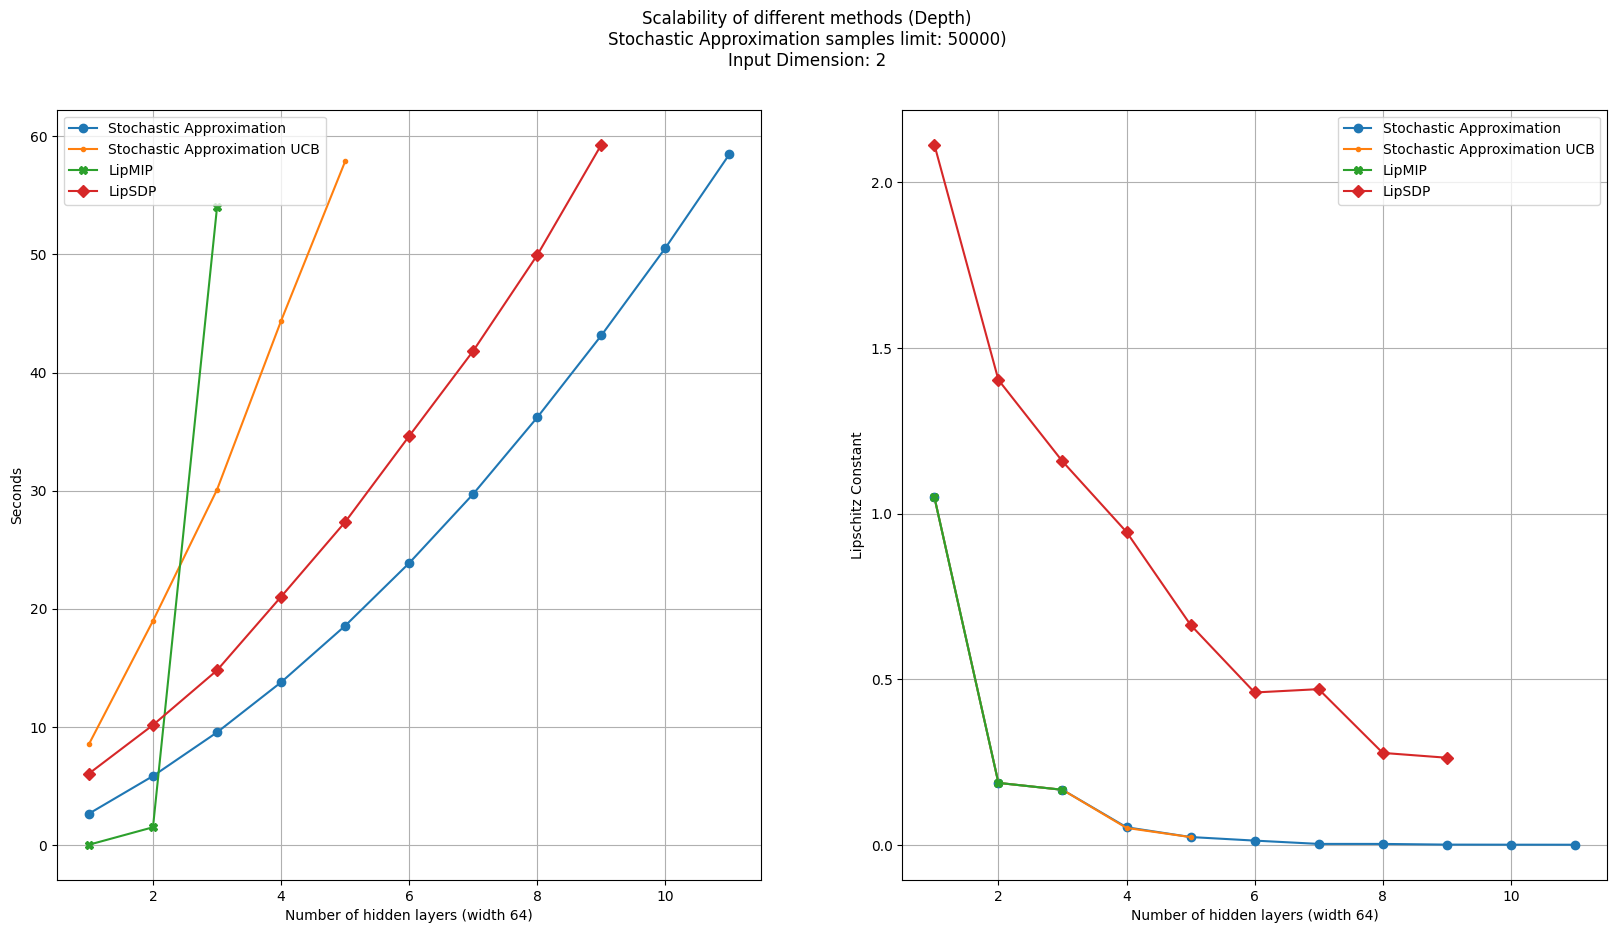

In [10]:
plot_results_seconds(max_depth, res, DIMENSION, SA_iter_limit=sa_iter_limit, methods=methods)